In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt
import selfies as sf
import mutations as mut
from functools import partial
import metrics as met
import functions as fn
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
import pandas as pd

c:\Users\marti\anaconda3\envs\thesis_3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Let's optimize a molecule!

Visualizing what the molecule in question is: 

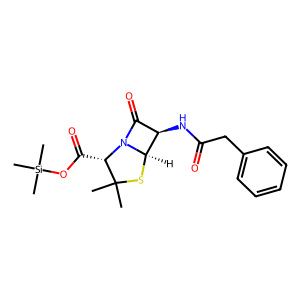

In [16]:
molecule = "CC1(C)S[C@@H]2[C@H](NC(=O)CC3=CC=CC=C3)C(=O)N2[C@H]1C(=O)O[Si](C)(C)C"
m = Chem.MolFromSmiles(molecule)
im=Draw.MolToImage(m)
display(im)

## Define what does it mean to be "optimal"
Since this is just a showcase, let the metrics be arbitrary: 
- biggest molecular weight (metric 1)
- least amount of carbon atoms (metric 2)

These metrics are linearly dependent, so posing the optimization problem like this will make it a good demonstration for multi-objective optimization.

In [17]:
metric_function_list = [
    partial(met.mol_mass_SMILES), #Metric 1
    #partial(met.specific_element_count_SMILES,element = 'C') #Metric 2
    partial(met.get_obj,obj="fexo")
]

## Defining mutations
Currently, there are two mutation operations implemented:
- bit flip
- fragment insertion

Here, we'll use both.

In [18]:
mutation_function_list = [
    partial(mut.symbol_swap),
    partial(mut.fragment_insertion,fragment_size=2),
    partial(mut.deletion,n=10)
]

# Initialization   

100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


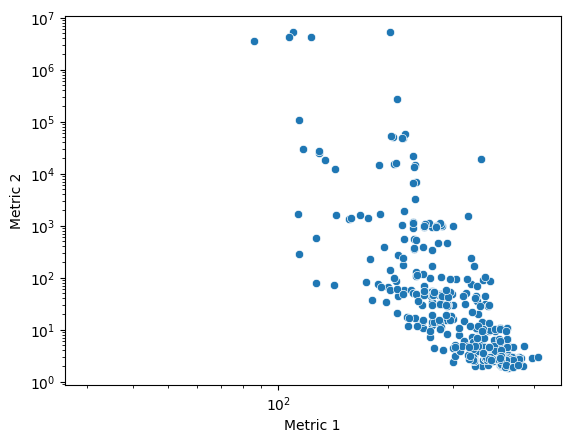

In [19]:
n = 500
initial_pop = fn.initialize_pop(n,sf.encoder(molecule),metric_function_list,mutation_function_list)
#flip metric due to minimizing optimization
initial_pop['Metric 2'] = initial_pop['Metric 2'].apply(met.one_over_metric)
sns.scatterplot(data=initial_pop, x="Metric 1", y="Metric 2")
plt.yscale('log')
plt.xscale('log')
plt.show()

## Identify best (Pareto optimal) solutions

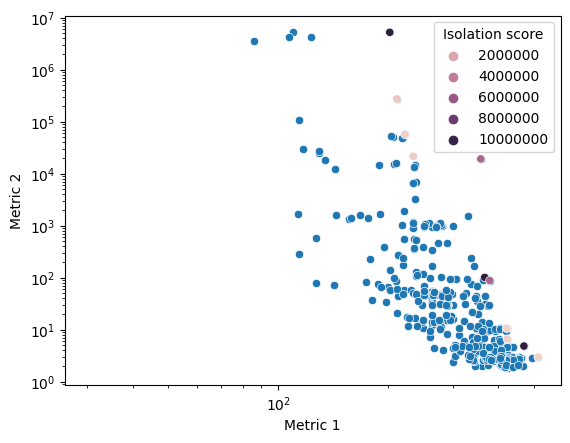

In [20]:
metrics = ['Metric 1', 'Metric 2']
initial_frontier = fn.get_pareto_optimal(initial_pop,metrics,minimize=False)
initial_frontier = fn.get_isolation(initial_frontier,metrics)
sns.scatterplot(data=initial_pop, x="Metric 1", y="Metric 2")
sns.scatterplot(data=initial_frontier, x="Metric 1", y="Metric 2", hue="Isolation score")
plt.yscale('log')
plt.xscale('log')
plt.show()

## Take best solutions as basis for new generations and keep optimizing


In [22]:
gen_history = pd.DataFrame(columns=initial_frontier.columns)

generations = 25

temp_frontier = initial_frontier.copy(deep=True)
for generation in range(generations):    
    temp_pop = fn.populate_from_df(temp_frontier,n,metric_function_list,mutation_function_list,
                                   generation)
    temp_pop.reset_index(drop=True,inplace=True)
    temp_pop['Metric 2'] = temp_pop['Metric 2'].apply(met.one_over_metric)
    temp_frontier = fn.get_isolation(fn.get_pareto_optimal(temp_pop,metrics,minimize=False),
                                    metrics=metrics)
    gen_history = pd.concat([gen_history,temp_frontier])

100%|██████████| 1/1 [00:00<00:00, 500.93it/s]


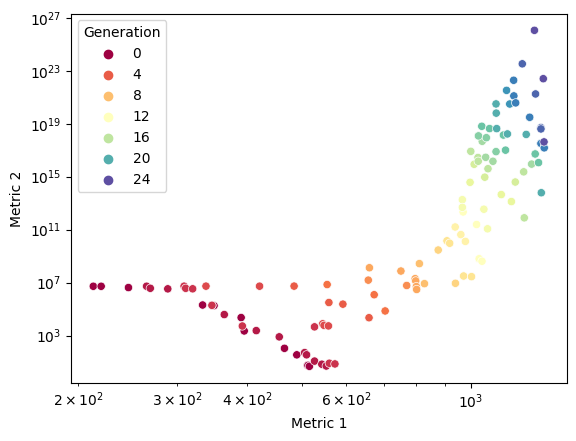

In [27]:
sns.scatterplot(data=gen_history, x="Metric 1", y="Metric 2", hue = "Generation", 
                palette=sns.color_palette("Spectral", as_cmap=True)  )
plt.yscale('log')
plt.xscale('log')
plt.show()

## Display latest generation

In [28]:
latest_gen = gen_history[gen_history['Generation']==gen_history['Generation'].max()]
latest_gen

,SMILES molecule,Isolation score,Generation,Metric 1,Metric 2,Pareto Front
58,CCS[P+][Si]CCC#P=[S-]#P=[C-][S-]=[P+]#S#[S-]=P...,2.262493e+26,24,1297.356016,1.131372e+26,1
86,P#C[S+][P+][PH](=CC[CH]PP=[S-]#S#[P+]=P#SCC[Si...,2.262493e+26,24,1345.287618,2.506024e+22,1
47,CC=[P-](C[CH]P[C-]=[P-]C[P+]#[B-]S#[P+]#[SH]=C...,2.262493e+26,24,1349.353710,4.213726e+17,1


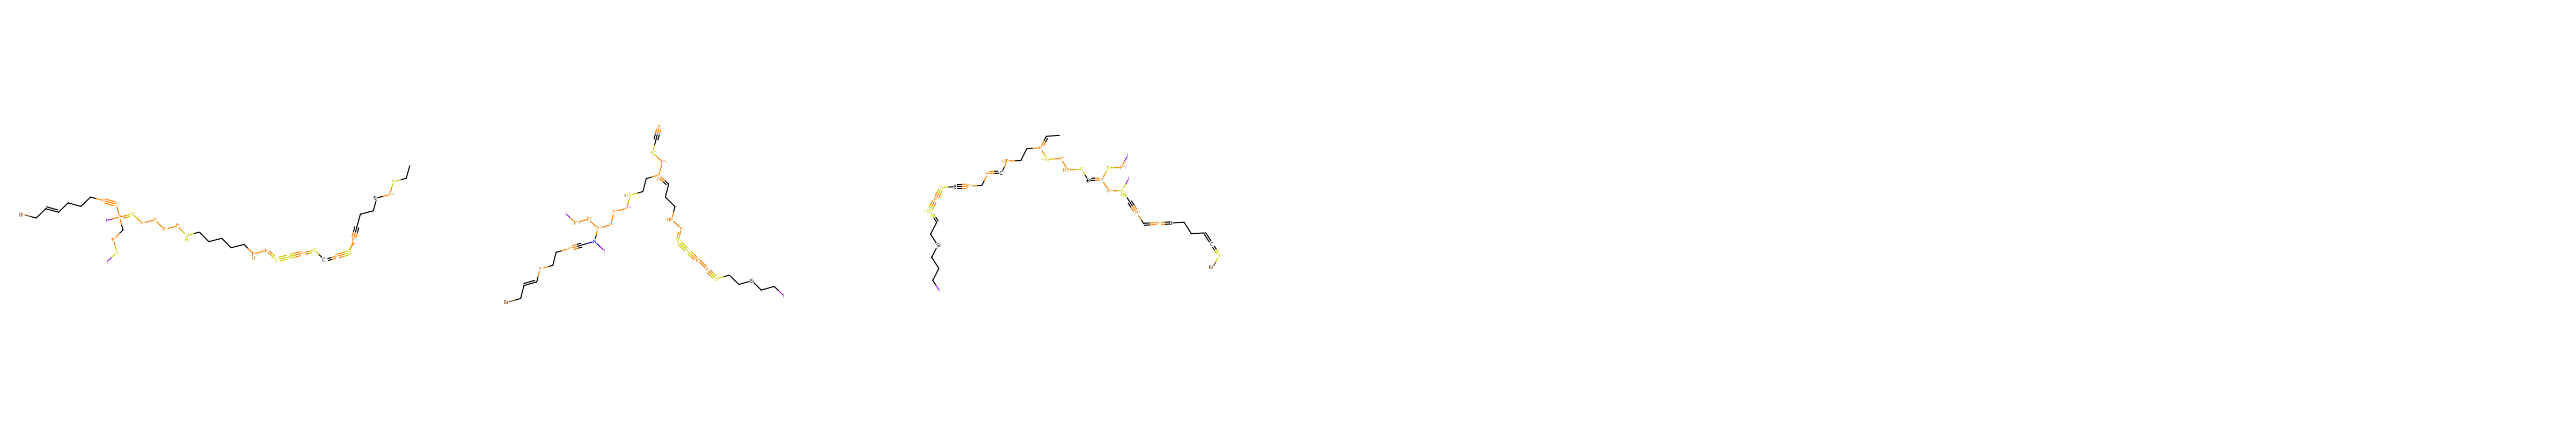

In [34]:
latest_gen_mol = [Chem.MolFromSmiles(molecule) for molecule in latest_gen["SMILES molecule"]]
img = Draw.MolsToGridImage(latest_gen_mol, 
                           molsPerRow=6, 
                           subImgSize=(800, 800), 
                           maxMols=len(latest_gen),
                           legends=None)
display(img)

# Display all generations

In [35]:
gen_history.sort_values('Generation', inplace=True)
all_gen_mol = [Chem.MolFromSmiles(molecule) for molecule in gen_history["SMILES molecule"]]
img = Draw.MolsToGridImage(all_gen_mol, 
                           molsPerRow=6, 
                           subImgSize=(800, 800), 
                           maxMols=len(gen_history),
                           legends=None)
display(img)

In [33]:
import pandas as pd
gen_history.to_csv("gen_history_thesis")

In [7]:
import os
os.getcwd()

'c:\\Users\\marti\\Desktop\\__SKOLA_VU\\__THESIS\\repo\\lead-optimization-pipeline\\pipeline'

In [8]:
import pandas as pd
df = pd.read_csv('gen_history_thesis')

In [9]:
df

,Unnamed: 0,SMILES molecule,Isolation score,Generation,Metric 1,Metric 2,Pareto Front
0,57,[C-]CC(C)SI,1.089305e+06,0,212.924043,5.260937e+06,1
1,24,CCC[SH]=[Si](C)OC(=O)[C@@H]1N2C(=O)[S+](#[P+][...,2.330294e+03,0,516.078536,4.713103e+00,1
2,72,C=CC=[B-][P+]#CC=CCC(=O)N1[C@H]2[CH][SH](C(C)C...,5.264861e+06,0,513.081707,5.568830e+00,1
3,36,CC(C)[SH]1[CH][C@H]2[P+]#[S+]C(=O)N([C@H]1C(=O...,4.190501e+06,0,512.001327,5.599519e+00,1
4,30,CC1CN(C(=O)Cc2ccccc2)N(I)C(=O)[S+]#[P+][CH][CH...,2.273206e+02,0,465.942457,1.081250e+02,1
...,...,...,...,...,...,...,...
119,100,CC=[P-](C[CH]P[C-]=[P-]C[P+]#[B-]S#[P+]#[SH]=C...,6.669497e+23,23,1332.404565,5.099941e+18,1
120,27,CC=[P-](C[CH]P[C-]=[P-]C[P+]#[B-][PH]#[P+]#[SH...,3.352379e+23,23,1332.414081,4.019983e+18,1
121,86,P#C[S+][P+][PH](=CC[CH]PP=[S-]#S#[P+]=P#SCC[Si...,2.262493e+26,24,1345.287618,2.506024e+22,1
122,58,CCS[P+][Si]CCC#P=[S-]#P=[C-][S-]=[P+]#S#[S-]=P...,2.262493e+26,24,1297.356016,1.131372e+26,1


In [10]:
fn.get_smiles_list(df)

['[C-]CC(C)SI',
 'CCC[SH]=[Si](C)OC(=O)[C@@H]1N2C(=O)[S+](#[P+][CH][CH][SH]1C(C)C)N2C(=O)Cc1ccccc1',
 'C=CC=[B-][P+]#CC=CCC(=O)N1[C@H]2[CH][SH](C(C)C)[C@H](C(=O)O[Si](C)(C)C)N1C(=O)[S+]#[P+]2',
 'CC(C)[SH]1[CH][C@H]2[P+]#[S+]C(=O)N([C@H]1C(=O)O[Si](C)(C)C)N2C(=O)CC=CCBr',
 'CC1CN(C(=O)Cc2ccccc2)N(I)C(=O)[S+]#[P+][CH][CH][SH]1',
 'Cc1ccccc1N(C)[C@H]1[CH]SC2C[C@H](C(=[S+])O[Si](C)(C)C)N(C2)O1',
 'CC(C)[SH]1[CH][C@H]2[P+]#[S+]C(=O)N([C@H]1C(Cl)O[Si](C)(C)C)N2C(=O)Cc1ccccc1',
 'Cc1ccccc1C(C)N1[CH][CH][SH]2CC[C@H](C([Si])CCF)N1C2',
 'CC1C[Si]C[CH]C[SH]2[CH][CH]N(CCC3=CCC=CC3)N(C1)C2',
 'CC=PCCSI',
 'CP(C)SI',
 'CC=C=[P-]C=CC=CC(C)N[C@H]1[CH]SC2C[C@H](C([Si])CC(C)C)N1C2',
 'CC=CC=CC=CCC(=O)N1[C@H]2[CH][SH](C(C)C)[C@H](C(Cl)O[Si](C)(C)C)N1C(=O)[S+]#[P+]2',
 '[C+][Si](C)(#[P-])OC(=O)[C@@H]1N2CCN(C(=O)CC=CCBr)[S+](#[P+][CH][CH][SH]1C(C)C)C2=O',
 'CC(C)[SH]1[CH][C@H]2[P+]#[S+]C(=O)N([C@H]1C(=O)O[Si](C)(C)C)N2C#[P+](=O)CC=CCBr',
 'CC(OO[Si](C)C)[C@@H]1N2CN(C(=O)CC=CCBr)[P+](#[S+]C2=O)[CH][CH][SH]